# 2025-10-31 Differentiation

* Computing derivatives in maintainable code

* Forward and reverse

* Algorithmic (automatic) differentiation

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# With Chebyshev polynomials
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

# A utility for evaluating our regression
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# And our gradient descent algorithm
function grad_descent(loss, grad, c0; gamma=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = copy(c0)
    chist = [copy(c)]
    lhist = [loss(c)]
    for it in 1:500
        g = grad(c)
        c -= gamma * g
        push!(chist, copy(c))
        push!(lhist, loss(c))
        if norm(g) < tol
            break
        end
    end
    (c, hcat(chist...), lhist)
end

grad_descent (generic function with 1 method)

## Nonlinear models

Instead of the linear model

$$ f \left( x, c \right) = V \left( x \right) c = c_0 + c_1 T_1 \left( x \right) + c_2 T_2 \left( x \right) + \cdots $$

let's consider a rational model with only three parameters

$$ f \left( x, c \right) = \frac{1}{c_1 + c_2 x + c_3 x^2} = \left( c_1 + c_2 x + c_3 x^2 \right)^{-1} $$

We'll use the same loss function

$$ L \left( c; x, y \right) = \frac{1}{2} \left\lvert \left\lvert f \left( x, c \right) - y \right\rvert \right\rvert^2 $$

We will also need the gradient

$$ \nabla_c L \left( c; x, y \right) = \left( f \left( x, c \right) - y \right)^T \nabla_c f \left( x, c \right) $$

where

$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} = - f \left( x, c \right)^2 $$
$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} x = - f \left( x, c \right)^2 x $$
$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} x^2 = - f \left( x, c \right)^2 x^2 $$

## Fitting a rational function

Now let's fit our rational function with gradient descent, as above.

In [2]:
f(x, c) = 1 ./ (c[1] .+ c[2].*x + c[3].*x.^2)

function gradf(x, c)
    f2 = f(x, c).^2
    [-f2 -f2.*x -f2.*x.^2]
end

function loss(c)
    r = f(x, c) - y
    0.5 * r' * r
end

function gradient(c)
    r = f(x, c) - y
    vec(r' * gradf(x, c))
end

gradient (generic function with 1 method)

c = [1.1380315133586891, 0.9808803838099355, 9.257852500955655]


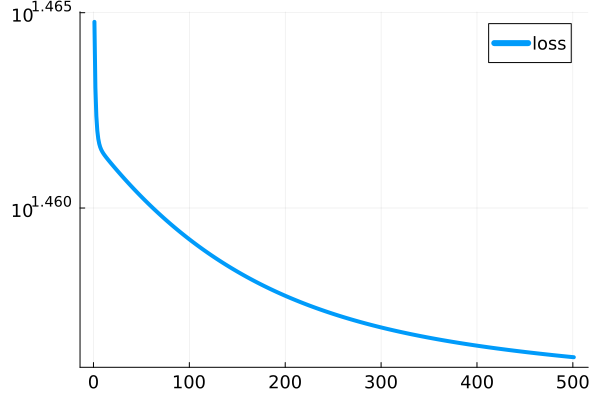

In [3]:
# Let's fit our Runge function with noise
x = LinRange(-1, 1, 200)
y = runge_noisy(x, .5)
c, _, lhist = grad_descent(loss, gradient, [1., 0, 10.], gamma=1e-2)
@show c

plot(lhist, yscale=:log10, label="loss")

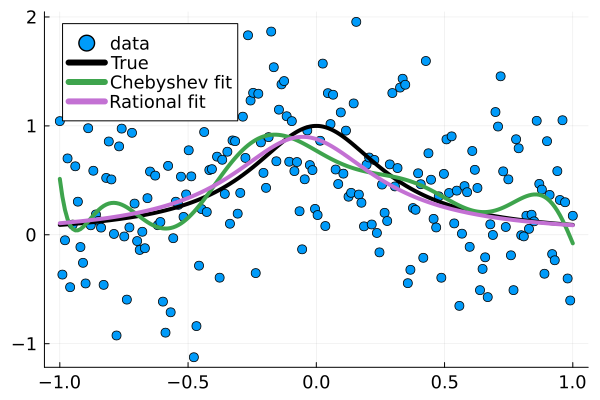

In [4]:
scatter(x, y, label="data")
V = vander_chebyshev(x, 12) # Will overfit for Chebyshev (fit to the noise!)
plot!(x -> runge(x), color=:black, label="True")
plot!(x, V * (V \ y), label="Chebyshev fit")
plot!(x -> f(x, c), label="Rational fit")

## Computing derivatives

How should we compute these derivatives as the model gets complicated?

Recall the definition of the derivative:

$$ \lim_{h \rightarrow 0} \frac{f \left( x + h \right) - f \left( x \right)}{h} $$

* How should we pick $h$?

* Too big: discretization error dominates (think of truncating the Taylor series)

* Too small: rounding error dominates

### Automatic step size selection

Walker and Pernice, Dennis and Schnabel developed ways to automatically choose the step size when computing the derivative numerically.

In [5]:
# Derivative via differancing
diff(f, x; h=1e-8) = (f(x+h) - f(x)) / h

# And automatic selection of h
function diff_wp(f, x; h=1e-8)
    """Diff using Walker and Pernice (1998) choice of step"""
    h *= (1 + abs(x))
    (f(x+h) - f(x)) / h
end

# Let's try it!
x = 10
@show diff(sin, x) - cos(x)
@show diff_wp(sin, x) - cos(x);

diff(sin, x) - cos(x) = -7.201219542896098e-8
diff_wp(sin, x) - cos(x) = 2.790787678730311e-8


## Symbolic differentiation

We can also use a package to symbolically differentiate like we would by hand.

In [6]:
using Pkg
pkg"add Symbolics"
using Symbolics

# Some setup
@variables x
Dx = Differential(x)

# And an example
y = sin(x)
Dx(y)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Differential(x)(sin(x))

### Product rule

This package can follow the product rule!

In [7]:
y = x
for _ in 1:2
    y = cos(y^π) * log(y)
end

# This will be... a lot
expand_derivatives(Dx(y))

((cos(x^π) / x - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))) / (log(x)*cos(x^π)) - ((3.141592653589793(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793)) / x - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*sin(x^π)*(cos(x^π)^2.141592653589793))*log(log(x)*cos(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))

The size of these expressions can grow **exponentially**!

## Hand-coded derivatives

With (mild) algebra abuse, the expression

$$ \frac{df}{dx} = f' \left( x \right) $$

is equivalent to

$$ df = f' \left( x \right) dx $$

In [8]:
function f(x)
    y = x
    for _ in 1:2
        a = y^π
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), diff_wp(f, 1.9)

(-1.5346823414986814, -34.032439961925064)

In [9]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y^π
        da = π * y^(π - 1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = dy / y
        y = b * c
        dy = db * c + b * dc
    end
    y, dy
end

df(1.9, 1)

(-1.5346823414986814, -34.032419599140475)

### Forward vs reverse mode

We can differentiate a composition $h \left( g \left( f \left( x \right) \right) \right)$ as

$$ \begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x
\end{align}$$

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname{d} h = \frac{dh}{dg} \left( \frac{dg}{df} \left( \frac{df}{dx} \operatorname{d} x \right) \right) $$

This expression means the same thing if we rearrange the parenthesis,

$$ \operatorname{d} h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname{d} x $$

## Reverse mode example

Let's do an example to better understand.

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} $$

Let's consider the function

$$ z = x \cdot y + \sin \left( x \right) $$

We can represent this in pesudocode as

```
x = ?
y = ?
a = x * y
b = sin(x)
z = a + b
```

Evaluating the derivative in the forward mode gives

```
dx = ?
dy = ?
da = y * dx + x * dy
db = cos(x) * dx
dz = da + db
```

and evaluating in the reverse mode gives

```
gz = ?
gb = gz
ga = gz
gy = x * ga
gx = y * ga + cos(x) * gb
```

## Automatic differentiation

In [10]:
using Pkg
pkg"add Zygote"
import Zygote

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [11]:
Zygote.gradient(f, 1.9)

(-34.03241959914049,)

## But how?

It's cool that Zygote works, but how does it actually work?

In [12]:
square(x) = x^2
# Let's look at the LLVM bitcode here
@code_llvm square(1.5)

; Function Signature: square(Float64)
;  @ In[12]:1 within `square`
define double @julia_square_35825(double %"x::Float64") #0 {
top:
; ┌ @ intfuncs.jl:370 within `literal_pow`
; │┌ @ float.jl:493 within `*`
    %0 = fmul double %"x::Float64", %"x::Float64"
    ret double %0
; └└
}


In [13]:
# And here is the LLVM bitcode of Zygote's derivative
@code_llvm Zygote.gradient(square, 1.5)

; Function Signature: gradient(typeof(Main.square), Float64)
;  @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:152 within `gradient`
define [1 x double] @julia_gradient_36053(double %"args[1]::Float64") #0 {
top:
;  @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:154 within `gradient`
; ┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:97 within `#88`
; │┌ @ In[12]:1 within `square`
; ││┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/chainrules.jl:222 within `ZBack`
; │││┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/lib/number.jl:12 within `literal_pow_pullback`
; ││││┌ @ promotion.jl:430 within `*` @ float.jl:493
       %0 = fmul double %"args[1]::Float64", 2.000000e+00
; └└└└└
;  @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:155 within `gradient`
  %"new::Tuple2.unbox.fca.0.insert" = insertvalue [1 x double] zeroinitializer, double %0, 0
  ret [1 x double] %"new::Tuple2.unbox.fca

## Types of algorithmic differentiation

* Source transformation: Fortran code in, Fortran code out

    * Duplicates compiler features, usually incomplete language coverage

    * Produces efficient code

* Operator overloading: C++ types

    * Hard to vectorize

    * Loops are effectively unrolled/inefficient

* Just-in-time compilation: tightly coupled with compiler

    * JIT lag

    * Needs dynamic language features (JAX) or tight integration with compiler (Zygote, Enzyme)

    * [Some sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)

## Forward or reverse mode

Pick forward or reverse mode depending upon the 'shape' of your function.

* One input, many outputs: use forward mode

    * "One input" can be looking in one direction

* Many inputs, one output: use reverse mode

    * Will need to traverse execution backwards ("tape")
 
    * Hierarchical checkpointing
 
* About square? Forward mode is usually a bit more efficient

## Ill-conditioned optimization

$$ L \left( c; x, y \right) = \frac 1 2 \lVert \underbrace{f \left( x, c \right) - y}_{r \left( c \right)} \rVert_{C^{-1}}^2 $$

Gradient of $L$ requires the Jacobian $J$ of the model $f$.

$$ g \left( c \right) = \nabla_c L = r^T \underbrace{\nabla_c f}_{J} $$

We can solve $g \left( c \right) = 0$ using a Newton method

$$ g \left( c + \delta c \right) = g \left( c \right) + \underbrace{\nabla_c g}_{H} \delta c + \mathcal{O} \left( \left( \delta c \right)^2 \right) $$

The Hessian requires the second derivative of $f$, which can cause problems

$$ H = J^T J + r^T \left( \nabla_c J \right) $$

## Newton-like methods for optimization

Solve

$$ H \delta c = - g \left( c \right) $$

Update $c \leftarrow c + \gamma \delta c$ using using a line search or trust region.

## Outlook

* The optimization problem can be solved using a Newton method.
It can be onerous to implement the needed derivatives.

* The Gauss-Newton method (see activity) is often more practical than Newton while being faster than gradient descent, though it lacks robustness.

* The Levenberg-Marquardt method provides a sort of middle-ground between Gauss-Newton and gradient descent.

* Many globalization techniques are used for models that possess many local minima.

* One pervasive approach is stochastic gradient descent, where small batches (e.g., 1 or 10 or 20) are selected randomly from the corpus of observations (500 in our current example), and a step of gradient descent is applied to that reduced set of observations.
This helps to escape saddle points and weak local minima.

* Among expressive models $f \left( x, c \right)$, some may converge much more easily than others.
Having a good optimization algorithm is essential for nonlinear regression with complicated models, especially those with many parameters $c$.

* Classification is a very similar problem to regression, but the observations $y$ are discrete, thus

    * models $f \left( x, c \right)$ must have discrete output

    * the least squares loss function is not appropriate

* [Why momentum really works](https://distill.pub/2017/momentum/)